## Define Config

In [1]:
from utils.config import GlobalConfig

config = GlobalConfig(
    window_size=48,
    missing_size=24,
    batch_size=4,
    data_num_samples=1000,
    model_config={
        "features": 1,
        "hidden_features": 256,
        "context_features": 128,
    },
    epochs=20,
    save_path="checkpoints"
)

## Test PhuLien

In [2]:
from data.phulien import PhuLienData

In [3]:
dataset = PhuLienData(config)

In [4]:
dataset[0].shape

torch.Size([4, 1, 48])

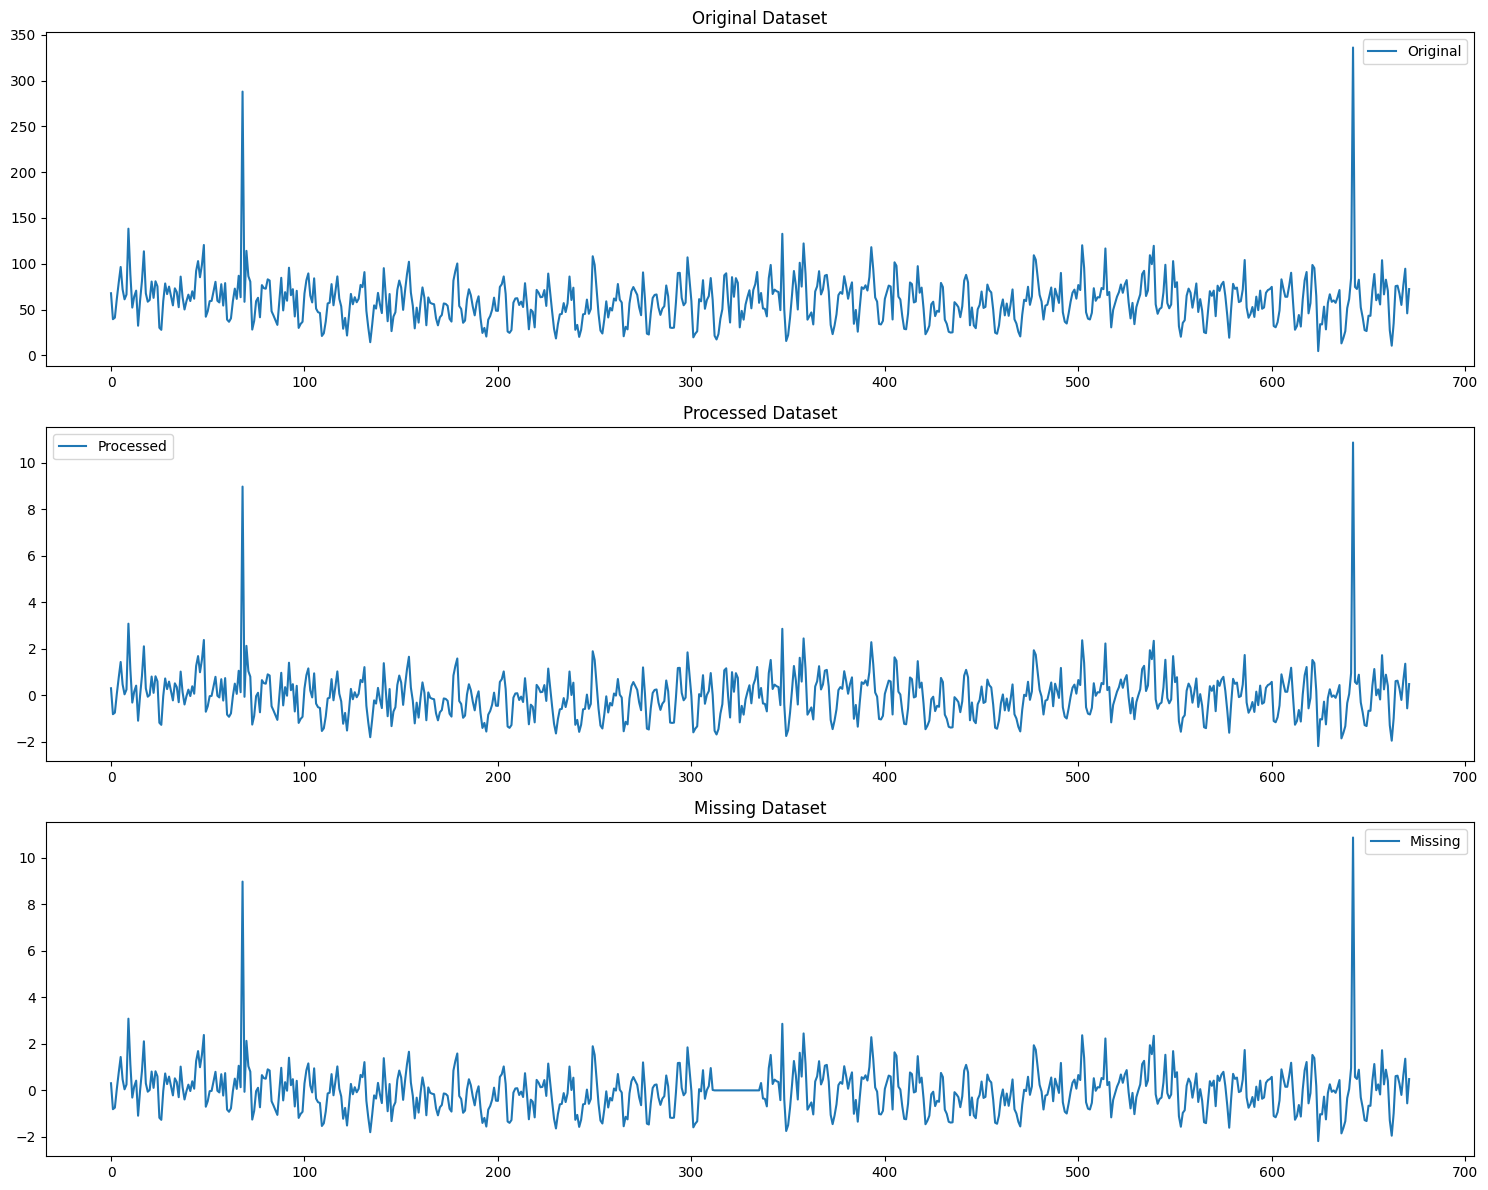

In [5]:
dataset.visualize()

In [6]:
window, mask = dataset.get_missing_window_and_mask()
window.shape, mask.shape

(torch.Size([1, 1, 48]), torch.Size([1, 1, 48]))

## Test Unet

In [7]:
import torch
from backbones.unet import Unet

In [8]:
backbone = Unet(config).to(config.device)

In [9]:
x = torch.rand(4, 1, 48).to(config.device)
# (batch_size, t_feature, 1). t_feature is the time feature, 1 for broadcast to all values in the window
t = torch.rand(4, 1, 1).to(config.device)

y = backbone(x, t)
y.shape == x.shape, y.shape

(True, torch.Size([4, 1, 48]))

## Test DDPM

In [10]:
import torch
from schedulers.ddpm import DDPMScheduler

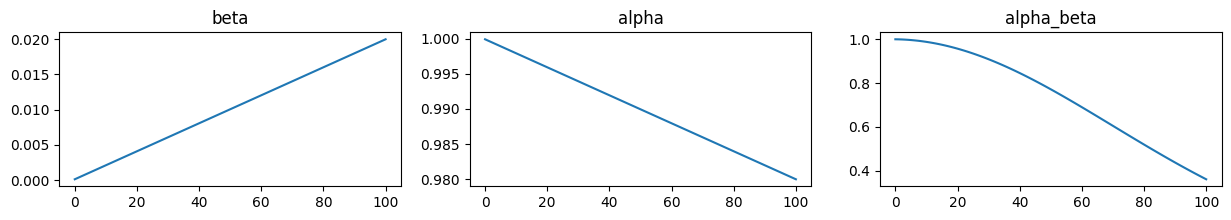

In [11]:
import matplotlib.pyplot as plt

beta1 = 1e-4
beta2 = 0.02
timesteps = 100
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()

fig, ax = plt.subplots(1, 3, figsize=(15, 2))
ax[0].plot(b_t)
ax[0].set_title('beta')
ax[1].plot(a_t)
ax[1].set_title('alpha')
ax[2].plot(ab_t)
ax[2].set_title('alpha_beta')
plt.show()
plt.close(fig)

In [12]:
schedulers = DDPMScheduler(config)

In [13]:
sample_mask = torch.zeros(1, 1, 48).to(config.device)
sample_mask[:, :, 12:36] = 1

output = schedulers(backbone, sample_mask)
output.shape == sample_mask.shape, output.shape

DDPMScheduler: 100%|██████████| 100/100 [00:00<00:00, 120.86it/s]


(True, torch.Size([1, 1, 48]))

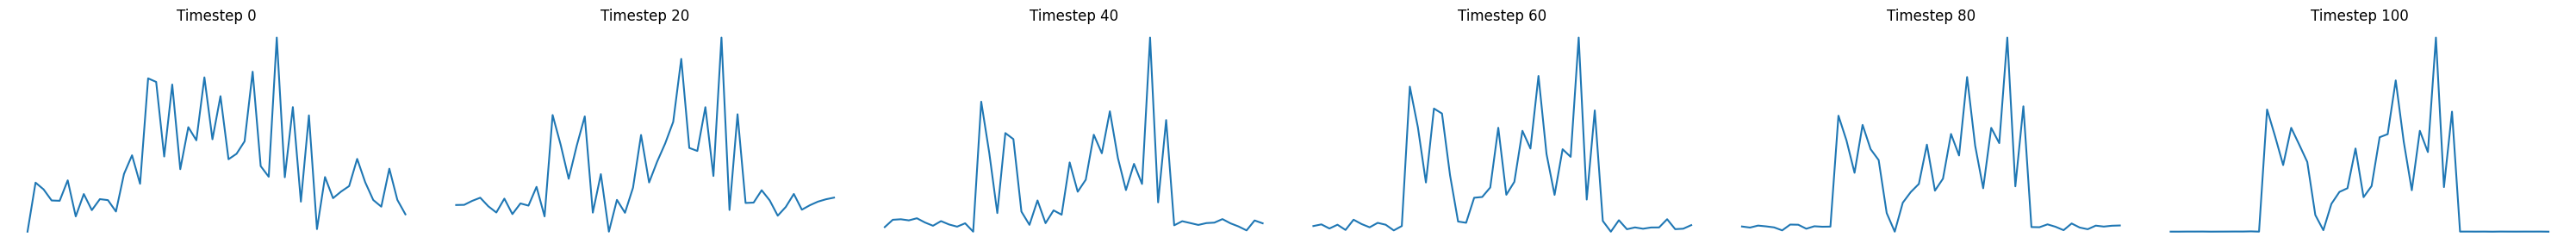

In [14]:
schedulers.visualize_trace_samples()

## Test Trainer

In [15]:
from trainer import Trainer

model_trainer = Trainer(
    config,
    dataset,
    backbone,
    schedulers
)
model_trainer.train()

c:\Users\minh5\anaconda3\envs\machine-learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧠 Training process begin.
- Timesteps: 100
- Batch size: 4
- Epochs: 20
- Device: cuda
- Dataset: PhuLienData
- Model: Unet
- Scheduler: DDPMScheduler


🚅 Epoch 1/20: 100%|██████████| 250/250 [00:05<00:00, 46.46it/s, loss=0.655]


📦 Model saved at epoch 1


🚅 Epoch 5/20: 100%|██████████| 250/250 [00:04<00:00, 55.70it/s, loss=0.824]


📦 Model saved at epoch 5


🚅 Epoch 9/20: 100%|██████████| 250/250 [00:04<00:00, 52.07it/s, loss=0.923]


📦 Model saved at epoch 9


🚅 Epoch 13/20: 100%|██████████| 250/250 [00:04<00:00, 53.32it/s, loss=0.709]


📦 Model saved at epoch 13


🚅 Epoch 17/20: 100%|██████████| 250/250 [00:04<00:00, 54.16it/s, loss=0.594]


📦 Model saved at epoch 17


🚅 Epoch 20/20: 100%|██████████| 250/250 [00:05<00:00, 49.76it/s, loss=0.783]


📦 Model saved at epoch 20
🏁 Training process complete at 94.181s


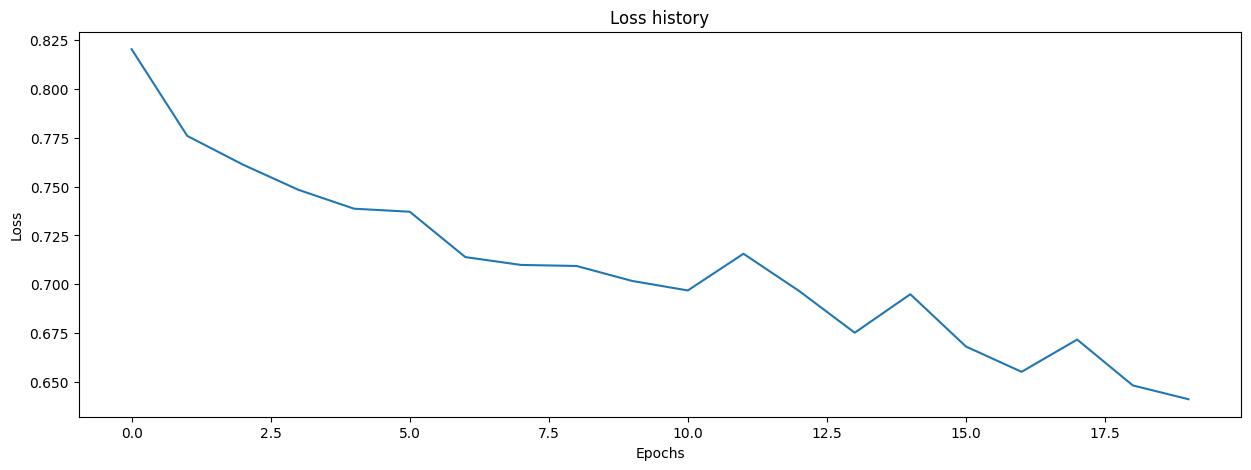

In [16]:
model_trainer.visualize_history()

## Test Predict

In [17]:
window, mask = dataset.get_missing_window_and_mask()
output = schedulers(backbone, mask)
output.shape

DDPMScheduler: 100%|██████████| 100/100 [00:00<00:00, 145.54it/s]


torch.Size([1, 1, 48])

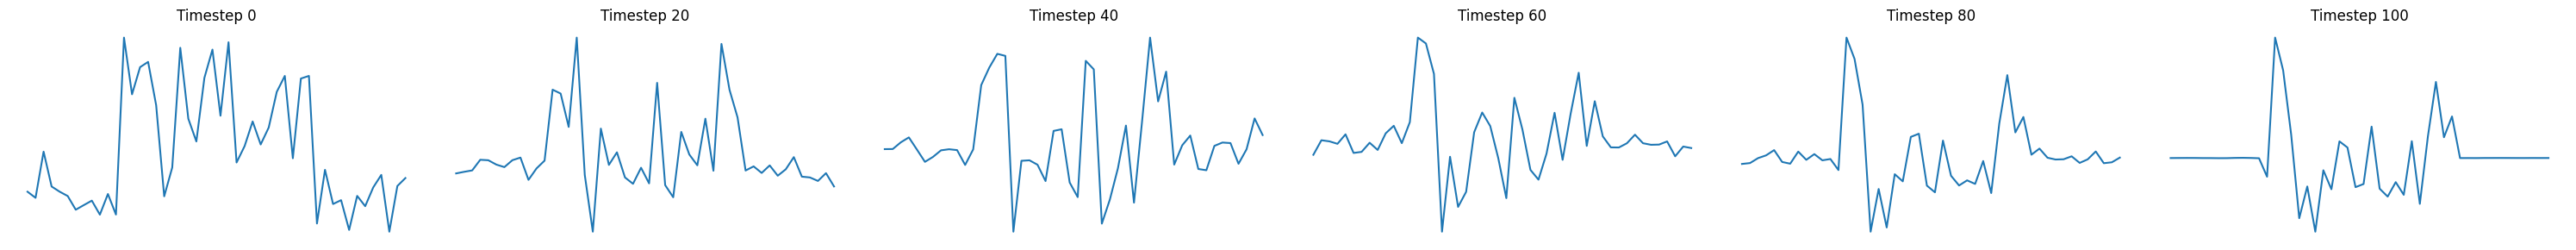

In [18]:
schedulers.visualize_trace_samples()

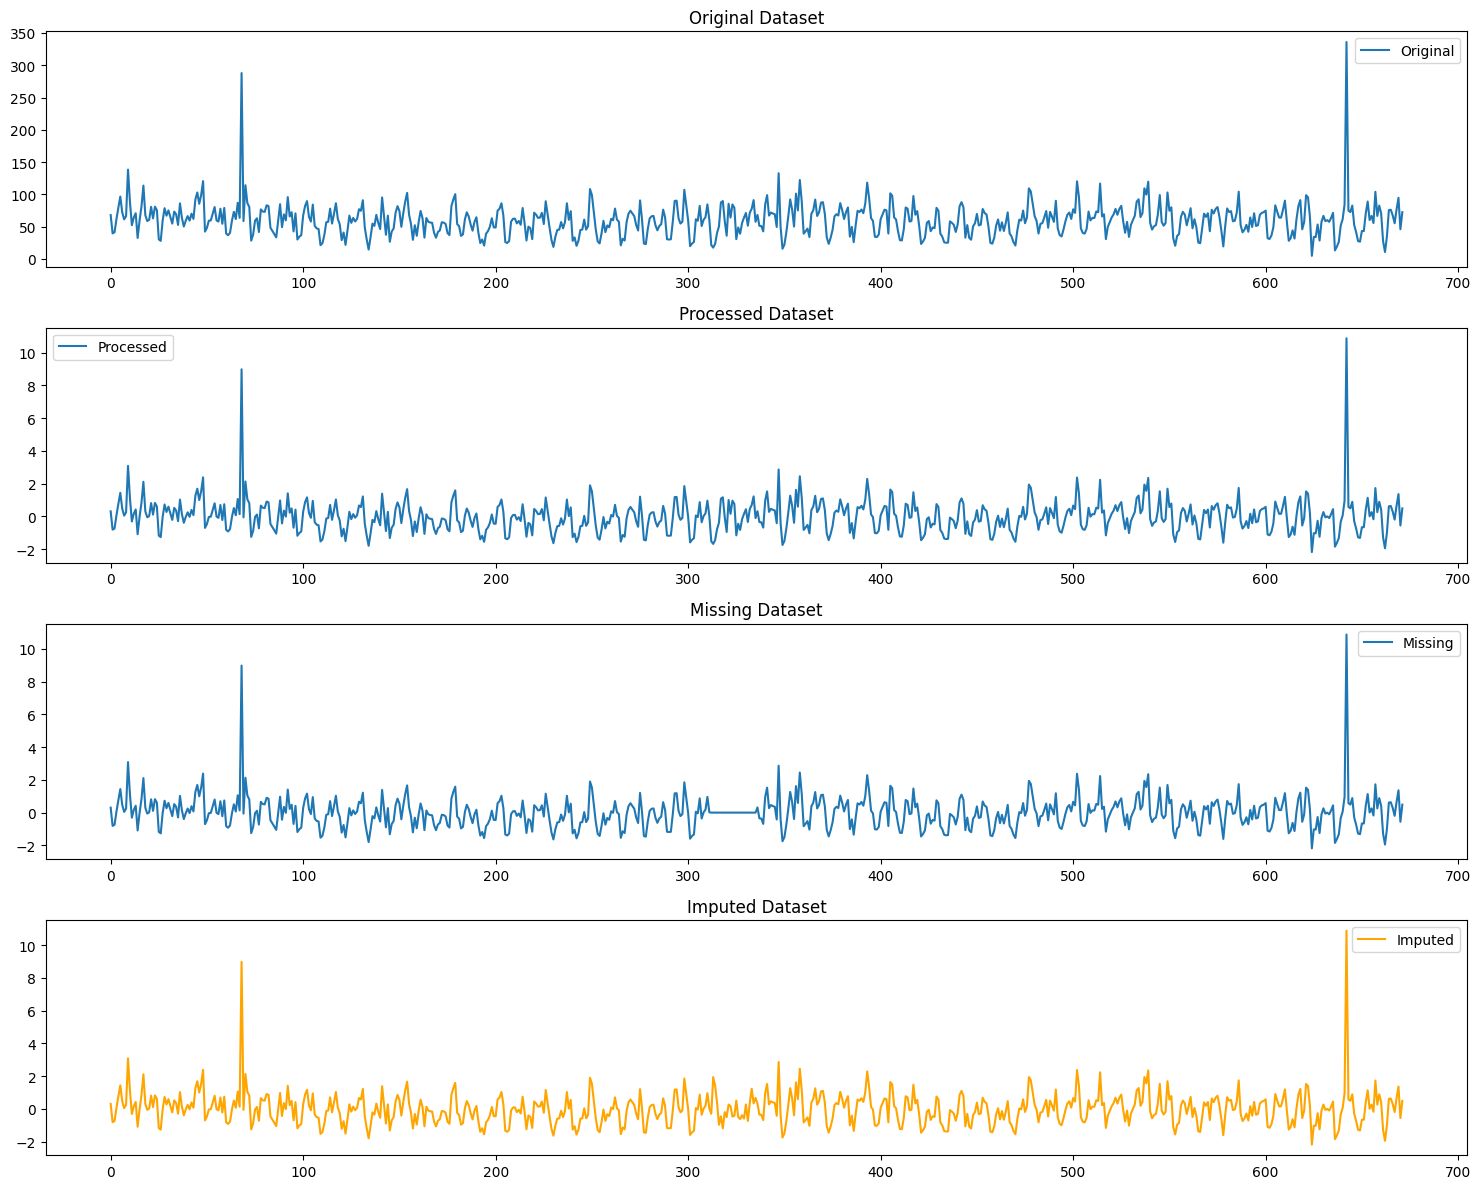

In [19]:
dataset.merge_result(output)
dataset.visualize()

In [20]:
from evaluate import Evaluator
evaluator = Evaluator(config, dataset, backbone, schedulers)

In [21]:
evaluator.evaluate(repeat=5)

Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


,Similarity,NMAE,R2,RMSE,FSD,FB,FA2
0,0.755720,0.378067,-0.093971,1.353302,0.078267,-1.003725,0.125000
1,0.751763,0.368286,-0.140915,1.256482,0.157112,-0.826793,0.208333
2,0.770539,0.377535,-0.246944,1.329937,0.135438,-0.869027,0.166667
3,0.795309,0.375244,-0.069034,1.379651,0.050476,-0.963259,0.375000
4,0.838975,0.302186,0.221564,1.135005,0.058583,-0.955784,0.166667


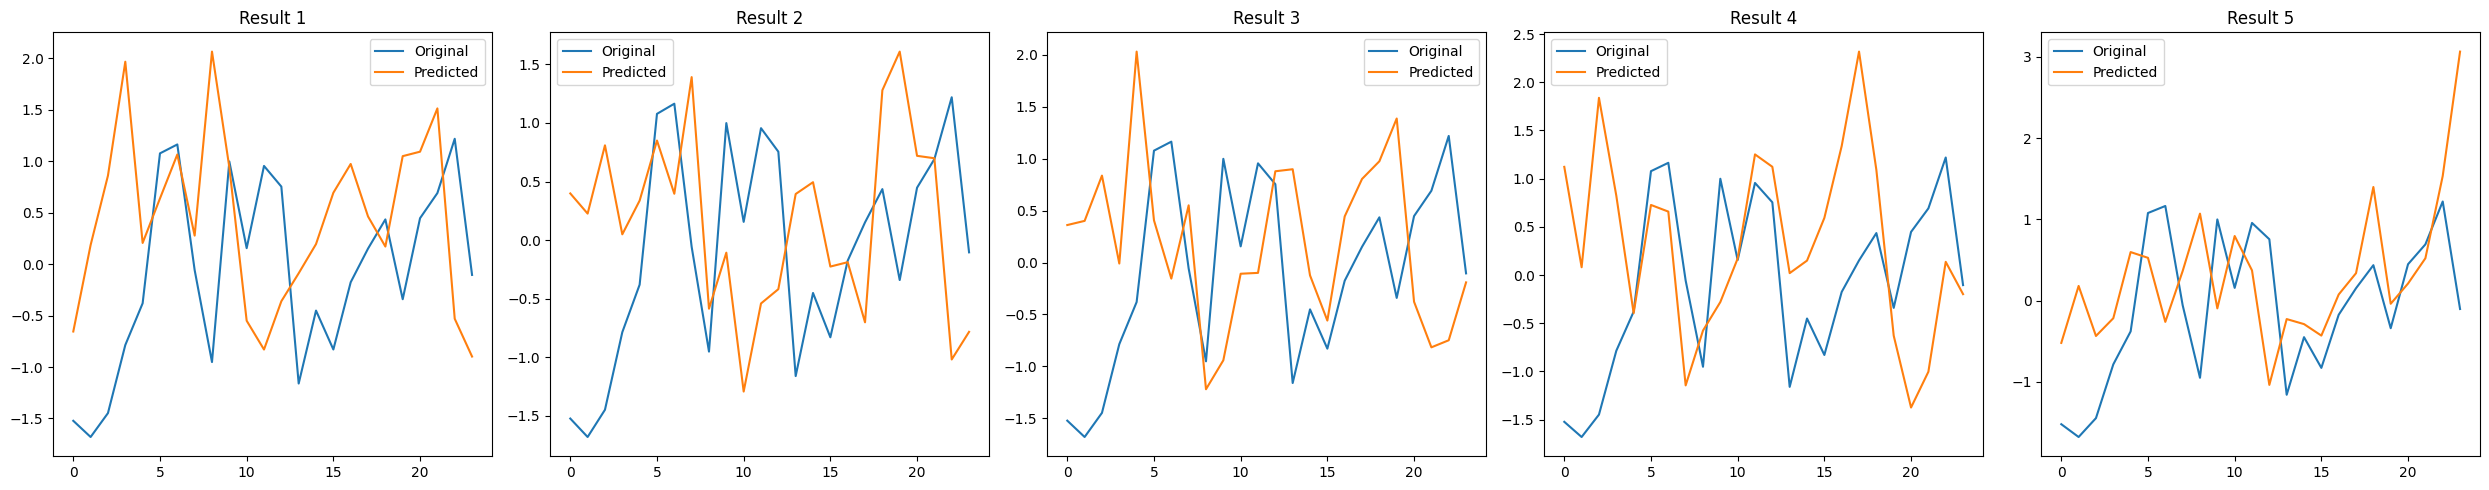

In [22]:
evaluator.visualize_result()